# Bayesian Reliability Chapter 4

Last updated: 07/28/2019<br>
Author: Travis Jefferies

This notebook walks through the Component Reliability Bayesian modeling paradigm presented in Bayesian Reliability Chapter 4.

Source:
“Bayesian Inference.” Bayesian Reliability, by Michael Hamada, Springer, 2008, pp. 85–125.

### 4.2.2 Failure Count Data

Failure count data record the number of times that a component fails in a specified period of time, where the component's fate is either repair or replace. The basic model for failure count data is the *Poisson* distribution.
* Poisson is appropriate when the probability of events occuring in disjoint time intervals is independent and the probability of two events occurring in a short time period is small

Poisson probability density function:

$$
f \left( y \, | \, \lambda \right) = \frac{\left( \lambda t \right)^{y} \exp{(-\lambda t)}}{y!}
$$

where the observed number of failures $y=0,1,2,\ldots, \lambda > 0$ is the mean number of failures per unit time, and *t* is the length of the specified time period.
* Note the mean = variance = $\lambda t$ is the most limiting characteristic of the Poisson distribution
* The mean number of failures per unit time $\lambda$ is the unknown model parameter the analyst wants to estimate
* *y* is the appropriate likelihood function
    * If there are *n* failure counts, say $y_{1}, \ldots , y_{n}$ in time periods of lengths $t_{1}, \ldots , t_{n}$, then under conditional independence and constant $\lambda$, the likelihood function consists of the product of the $m$ individual likelihood functions.
    * We must specify a prior on $\lambda$
    
***Poisson Prior: Gamma***

Gamma distribution is a conjugate prior distribution for Poisson.

If

$$
Y_{i} \sim Poisson \left( \lambda t_{i} \right), i = 1, \ldots , n
$$

where $y_{1}, \ldots , y_{n}$ are $n$ observed failure counts, and the prior distribution for $\lambda$ is

$$
\lambda \sim Gamma \left( \alpha, \beta \right)
$$

then the posterior distribution of $\lambda$ is

$$
\lambda \, | \, y \sim Gamma \left( \alpha + \sum^{n}_{i=1} y_{i} , \beta + \sum^{n}_{i=1} t_{i} \right)
$$

where $y = \left(y_{1}, \ldots , y_{n}\right)$.
* $\beta$ can be interpretted as a prior sample size in constrast with the data sample size $\sum^{n}_{i=1} t_{i}$
* $\alpha$ is the prior number of failures in contrast with the observed number of failures $\sum^{n}_{i=1} y_{i}$

***Example 4.2: Poisson model for supercomputer failure count data***

Consider modeling the monthly number of failures of supercomputer components using a Poisson distribution. The supercomputer consists of 47 "identical" memory units and Table 4.1 presents their monthly number of failures for the first month of operation. Let $y_{1}, \ldots , y_{47}$ denote the monthly number of failures recorded for the memory units. With $t_{i} = 1$ month, we model the failure count the data by the Poisson distribution:

$$
Y_{i} \sim Poisson \left( \lambda t \right) = Poisson \left( \lambda \right) \: , \: i = 1, \ldots, 47
$$

where $\lambda$ is the mean monthly number of failures.

The engineers expect that there shouldn't be no more than 10 failures for each component in the first month of operation. We can translate this to a gamma prior distribution on $\lambda$ with a mean of five:

$$
\lambda \sim Gamma \left( \alpha=5 , \beta=1 \right)
$$

Using this prior, the probability that $\lambda$ exceeds 10 is 0.03. Using the equation above, we can calculate the posterior distribution:

$$
\begin{align*}
\lambda \, | \, y &\sim Gamma \left( \alpha + \sum^{n}_{i=1} y_{i} , \beta + \sum^{n}_{i=1} t_{i} \right) \\
 &= Gamma \left( 5 + 132 , 1 + 47 \right) \\ 
 &= Gamma \left( 137,48 \right)
\end{align*}
$$

In [2]:
/*Source: https://www4.stat.ncsu.edu/~wilson/BR/table41.txt*/
Title "Chapter 4 Table 4.1";
data table4_1;
    input Failures;
    cards;
1
5
1
4
2
3
1
3
6
4
4
4
2
3
2
2
4
5
5
2
5
3
2
2
3
1
1
2
5
1
4
1
1
1
2
1
3
2
5
3
5
2
5
1
1
5
2
proc print; run;

Obs,Failures
1,1
2,5
3,1
4,4
5,2
6,3
7,1
8,3
9,6
10,4


Obs,sum_fails,count_subjects
1,132,47

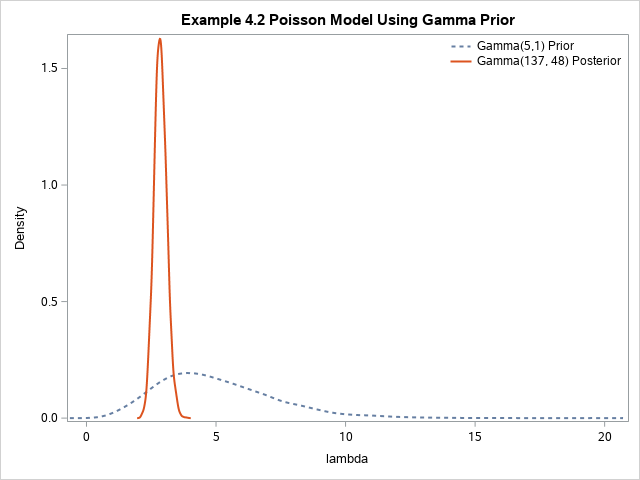

In [20]:
%let gamma_prior_alpha = 5;
%let gamma_prior_beta = 1;

Title "Example 4.2 Failure Count Data";
proc sql noprint;
    create table tbl as
        select sum(Failures) as sum_fails, count(Failures) as count_subjects
        from table4_1;
quit;
proc print data=tbl; run;

proc mcmc data=tbl outpost=ex4_2 seed=23 nmc=10000 maxtune=0 statistics=none diagnostics=none plots=none;
   ods exclude nobs parameters;
   parm prior_ post;
   begincnst;
       gamma_post_alpha = &gamma_prior_alpha. + sum_fails;
       gamma_post_beta = &gamma_prior_beta. + count_subjects;
   endcnst;
   prior prior_ ~ gamma(&gamma_prior_alpha., iscale=&gamma_prior_beta.);
   prior post ~ gamma(gamma_post_alpha, iscale=gamma_post_beta);
   model general(0);
run;

ods graphics on;
Title "Example 4.2 Poisson Model Using Gamma Prior";
proc sgplot data=ex4_2;
density prior_ / type=kernel lineattrs=(pattern=2) scale=density legendlabel='Gamma(5,1) Prior';
density post / type=kernel lineattrs=(pattern=1) scale=density legendlabel='Gamma(137, 48) Posterior';
keylegend / location=inside position=topright across=1 noborder linelength=20;
xaxis label='lambda'; 
run;

Given this new posterior, we can now calculate the expected monthly number of failures $E\left( \lambda \, | \, y \right)$:

$$
E\left( \lambda \, | \, y \right) = \frac{\alpha^{*}}{\beta^{*}} = 137/48 = 2.85
$$

the posterior standard deviation is:

$$
\sqrt{\text{Var}\left( \lambda \, | \, y \right)} = \sqrt{\alpha^{*} / \beta^{*2}} = 0.24
$$

Let's calculate the 95% credible interval:

In [21]:
%let alpha = 0.025;
%let ci_low = %sysevalf(&alpha*100);
%let ci_high = %sysevalf((1-&alpha)*100);
%let ct = %sysevalf(&ci_high - &ci_low);

proc rank data=ex4_2 out=ranked groups=100;
   ranks weightrank;
   var post;
run;

ods graphics off;
proc univariate data=ranked noprint;
   var post;
   output out=pctl pctlpts=&ci_low. &ci_high. pctlpre=p;
run;

ods graphics on;
title "Example 4.2 &ct% posterior probability interval";
proc print data=pctl;
run;

Obs,p2_5,p97_5
1,2.39625,3.35539


Thus we can expect between 2 and 3 failures per month.